### Step 1: Import Libraries
In this step, we import the necessary libraries:
- **TensorFlow/Keras:** For building and training the Deep Learning model.
- **OpenCV (cv2):** For image processing and segmentation.
- **Pandas/NumPy:** For data handling and file path management.
- **Matplotlib:** For visualizing results and images.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Check TensorFlow version and GPU availability
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-12-12 06:53:16.315961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765522396.603811      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765522396.683450      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0
GPU Available: False


2025-12-12 06:53:38.091397: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Phase 1: Image Acquisition
Here, we load the dataset from the directory.
- We specifically filter for images with **400X magnification** because they provide the highest resolution and detail for tissue analysis.
- The data is parsed into a Pandas DataFrame containing the file paths and their corresponding labels (Benign or Malignant).
- We split the data into **Training (80%)** and **Validation (20%)** sets.

In [2]:
dataset_dir = '/kaggle/input/breakhis' 
data = []

print("Loading images, please wait...")
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.png') and '400X' in root: # الشرط المهم (400X)
            label = 'malignant' if 'malignant' in root.lower() else 'benign'
            filepath = os.path.join(root, file)
            data.append([filepath, label])

df = pd.DataFrame(data, columns=['filename', 'class'])
print(f"Total 400X Images Found: {len(df)}")

# Stratified split to ensure balanced classes in train/val sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
print(f"Training Images: {len(train_df)}")
print(f"Validation Images: {len(val_df)}")

Loading images, please wait...
Total 400X Images Found: 1820
Training Images: 1456
Validation Images: 364


## Phase 2: Image Enhancement & Preprocessing
To improve model performance and generalization, we apply **Data Augmentation** techniques:
1.  **Rescaling:** Normalizing pixel values to the range [0, 1] (1./255).
2.  **Augmentation:** Applying random rotations, zooms, and flips (horizontal & vertical). This simulates new data and prevents the model from overfitting to the training set.

In [3]:
# Data Augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255) # الاختبار بدون تغيير في الصور

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1456 validated image filenames belonging to 2 classes.
Found 364 validated image filenames belonging to 2 classes.


## Phase 4: Image Recognition - Model Architecture
We utilize **Transfer Learning** with the **DenseNet121** architecture.
- **Why DenseNet121?** It is highly effective for medical imaging due to its dense connections, allowing it to capture fine tissue details better than standard CNNs.
- **Fine-Tuning:** We set `trainable=True` to unfreeze the model weights, allowing it to adapt its pre-trained knowledge to our specific breast cancer dataset.
- **Custom Head:** We add a global average pooling layer, batch normalization for stability, and a final Dense layer with Sigmoid activation for binary classification.

In [4]:
# Load pre-trained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the base model for fine-tuning
base_model.trainable = True 

# Build the final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(), # بيظبط الاستقرار
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4), 
    layers.Dense(1, activation='sigmoid')
])

# Compile with a low learning rate for stable fine-tuning
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,304,257 (27.86 MB)

 Trainable params: 7,218,561 (27.54 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [5]:
checkpoint = ModelCheckpoint("best_densenet_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

print("Starting Training...")
history = model.fit(
    train_generator,
    epochs=20, 
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)
print("Training Done!")

Starting Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6398 - loss: 0.6411 
Epoch 1: val_accuracy improved from -inf to 0.60989, saving model to best_densenet_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 736s 14s/step - accuracy: 0.6403 - loss: 0.6406 - val_accuracy: 0.6099 - val_loss: 0.6464
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7271 - loss: 0.5454 
Epoch 2: val_accuracy improved from 0.60989 to 0.67857, saving model to best_densenet_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 649s 14s/step - accuracy: 0.7276 - loss: 0.5447 - val_accuracy: 0.6786 - val_loss: 0.5666
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7842 - loss: 0.4815 
Epoch 3: val_accuracy improved from 0.67857 to 0.71154, saving model to best_densenet_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 656s 14s/step - accuracy: 0.7845 - loss: 0.4809 - val_accuracy: 0.7115 - val_loss: 0.5181
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8170 - loss: 0.4217 
Epoch 4: val_accur

## Model Training
We train the model using the training generator and validate it against the validation set.
- **Callbacks:**
    - `ModelCheckpoint`: Saves the best version of the model based on validation accuracy.
    - `EarlyStopping`: Stops training if accuracy does not improve for 5 epochs to prevent overfitting and save time.

In [6]:

checkpoint = ModelCheckpoint("best_densenet_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

print("Starting Training...")
history = model.fit(
    train_generator,
    epochs=20, # ممكن يوقف قبل كدة لو وصل لنتيجة حلوة
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)
print("Training Done!")

Starting Training...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9593 - loss: 0.1379 
Epoch 1: val_accuracy improved from -inf to 0.94231, saving model to best_densenet_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 642s 14s/step - accuracy: 0.9592 - loss: 0.1380 - val_accuracy: 0.9423 - val_loss: 0.1424
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9605 - loss: 0.1292 
Epoch 2: val_accuracy did not improve from 0.94231
46/46 ━━━━━━━━━━━━━━━━━━━━ 644s 14s/step - accuracy: 0.9603 - loss: 0.1294 - val_accuracy: 0.9396 - val_loss: 0.1369
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9442 - loss: 0.1558 
Epoch 3: val_accuracy improved from 0.94231 to 0.94505, saving model to best_densenet_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 641s 14s/step - accuracy: 0.9444 - loss: 0.1554 - val_accuracy: 0.9451 - val_loss: 0.1382
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9597 - loss: 0.1300 
Epoch 4: val_accuracy improved from 0.94505 

## Evaluation & Results
Visualizing the training process to check for convergence.
- **Accuracy Graph:** Shows how well the model is learning.
- **Loss Graph:** Shows the error rate decreasing over time.
- Ideally, the validation accuracy should track close to the training accuracy.

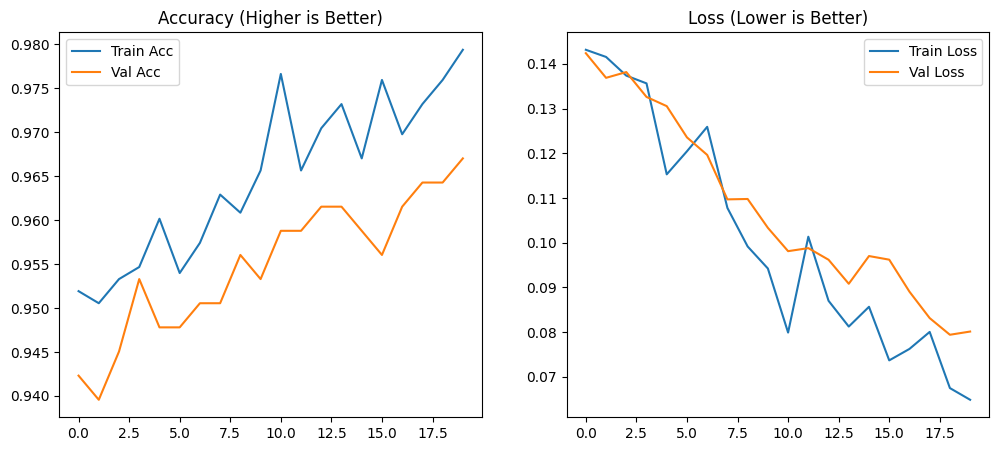

Final Validation Accuracy: 96.70%


In [7]:

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy (Higher is Better)')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Lower is Better)')
plt.legend()

plt.show()

print(f"Final Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")

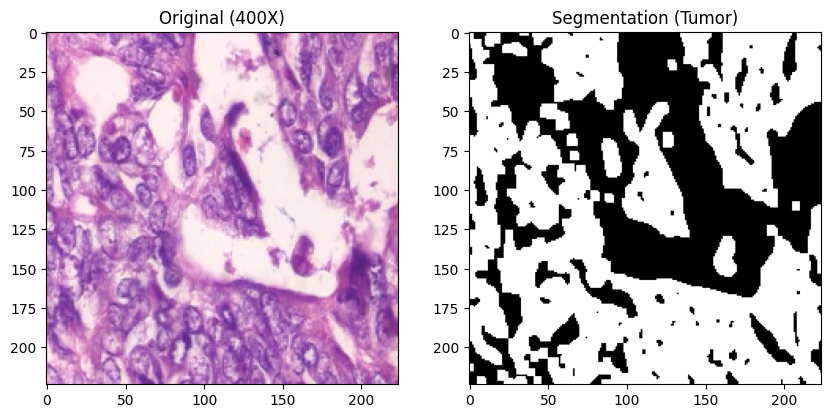

In [8]:
def show_segmentation_demo():
   
    sample = train_df[train_df['class'] == 'malignant'].sample(1).iloc[0]
    path = sample['filename']
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    
    # Segmentation Steps
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Otsu Thresholding
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
   
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
  
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(img_resized); plt.title("Original (400X)")
    plt.subplot(1, 2, 2); plt.imshow(opening, cmap='gray'); plt.title("Segmentation (Tumor)")
    plt.show()

show_segmentation_demo()